In [75]:
import itertools

import numpy as np


def l2_loss(curve, target):
    return np.mean(np.square(target-curve))


def l1_loss(curve, target):
    return np.mean(np.abs(target-curve))


class RandomWalker:

    def __init__(self, data_files):
        sorted_data_files = sorted(data_files)
        var = np.load(sorted_data_files[0], allow_pickle=True)["var"][1:]
        self.chiN = var
        self.frac = []
        self.betti_curve_map = np.empty((len(sorted_data_files), len(var)), dtype=object)
        for idx, dataset in enumerate(sorted_data_files):
            frac = dataset.split("_frac-")[-1].split(".npz")[0]
            self.frac.append(frac)
            data = np.load(dataset, allow_pickle=True)
            for key in data.keys():
                if "betti" not in key:
                    continue
                for jdx in range(len(var)):
                    if type(self.betti_curve_map[idx, jdx]) != dict:
                        self.betti_curve_map[idx, jdx] = {}
                    self.betti_curve_map[idx, jdx][key] = data[key][jdx+1]

    def get_tuple_info(self, tuple):
        return (self.frac[tuple[0]], self.chiN[tuple[1]])

    def compute_loss(self, current_tuple, target_tuple, loss_func=l1_loss):
        current_data = self.betti_curve_map[current_tuple]
        target_data = self.betti_curve_map[target_tuple]

        loss = 0.0

        for key in current_data.keys():
            loss += loss_func(current_data[key], target_data[key])

        return loss

    def check_move_ok(self, current_tuple, move):
        shape = self.betti_curve_map.shape
        post_move = (current_tuple[0] + move[0], current_tuple[1] + move[1])
        for size, idx in zip(shape, post_move):
            if idx < 0 or idx >= size:
                return None
        return post_move

    def check_convex_op_possible(self, starting_tuple, target_tuple, verbose=False):
        moves = [-1, 0, 1]
        moves = list(itertools.product(moves, moves))
        moves.remove((0,0))

        current_tuple = starting_tuple
        loss = self.compute_loss(current_tuple, target_tuple)
        next_tuple = current_tuple

        if next_tuple == target_tuple:
            return True

        if verbose:
            print(next_tuple, loss)

        while next_tuple is not None:

            next_tuple = None

            for move in moves:
                some_tuple = self.check_move_ok(current_tuple, move)
                if some_tuple is None:
                    continue
                new_loss = self.compute_loss(some_tuple, target_tuple)
                if new_loss < loss:
                    loss = new_loss
                    next_tuple = some_tuple
            if verbose:
                print(next_tuple, loss)

            current_tuple = next_tuple
            
            if next_tuple == target_tuple:
                return True
        
        return False

In [76]:
import os
import glob
import pathlib

data_dir = pathlib.Path(os.environ["DATA_DIR"])
inputs = glob.glob(str(data_dir / "topolymer/processed/cubic_phom/r-5_l-10_frac-*"))

In [77]:
rw = RandomWalker(inputs)

In [84]:
results = []
for i in range(40):
    start = (int(i%4), int(i/4))
    for j in range(40):
        if i == j:
            continue
        end = (int(j%4), int(j/4))
        result = rw.check_convex_op_possible(start, end)
        results.append(result)
np.mean(results)

0.4891025641025641

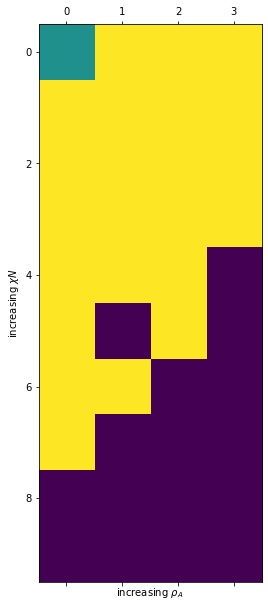

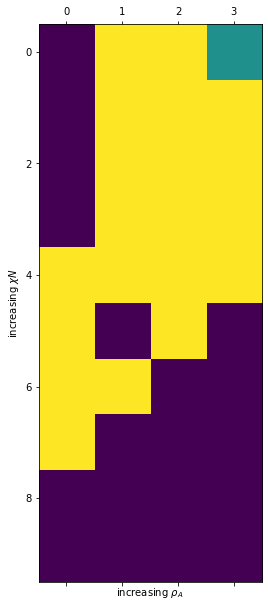

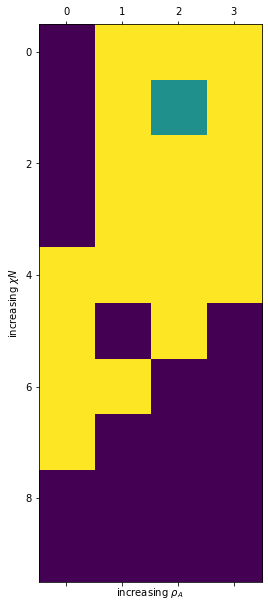

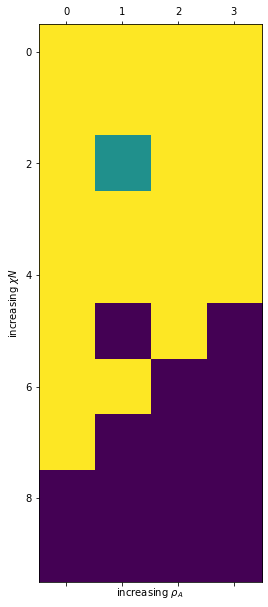

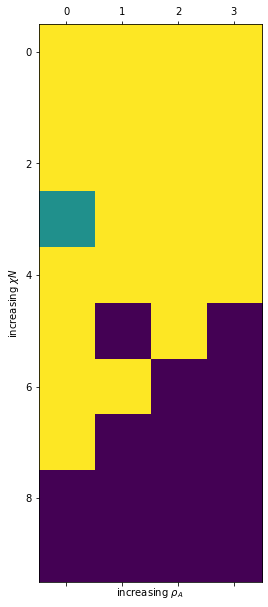

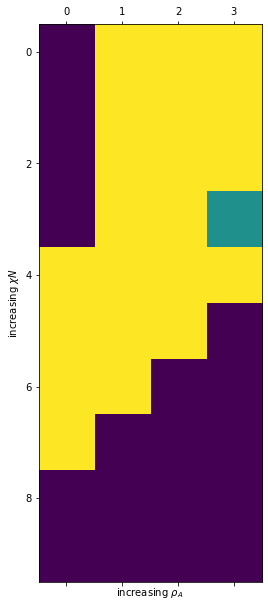

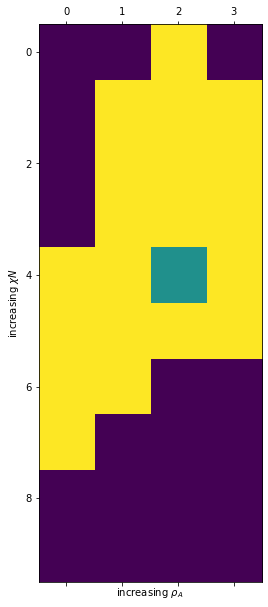

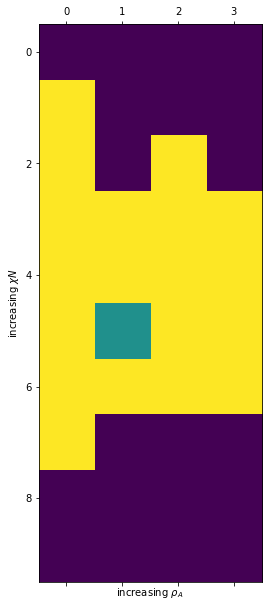

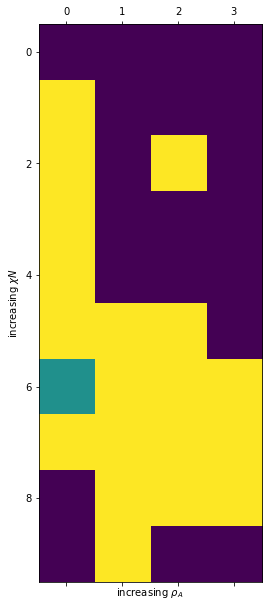

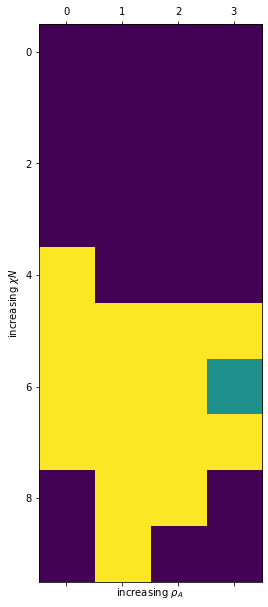

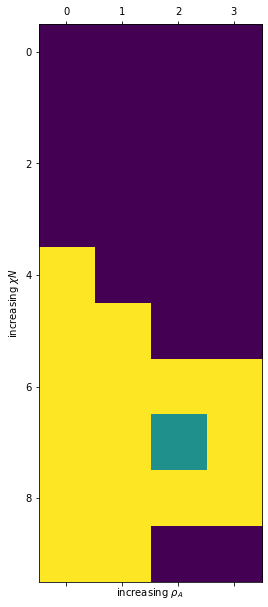

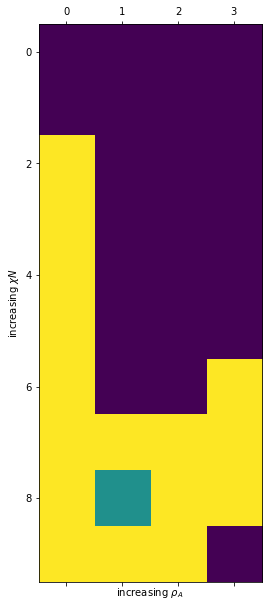

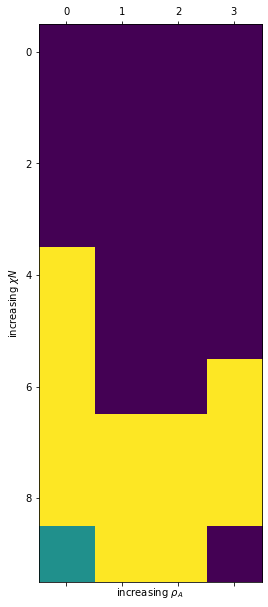

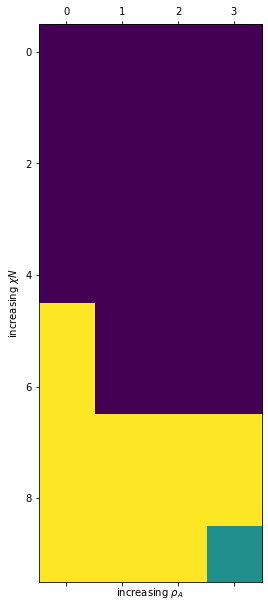

In [100]:

for i in np.arange(0,40,3):
    results = []
    start = (int(i%4), int(i/4))
    for j in range(40):
        if i == j:
            results.append(0.5)
            continue
        end = (int(j%4), int(j/4))
        result = rw.check_convex_op_possible(start, end)
        results.append(result)
    plt.matshow(np.reshape(results, (10,4)))
    plt.ylabel(r'increasing $\chi N$')
    plt.xlabel(r'increasing $\rho_A$')

In [91]:
import matplotlib.pyplot as plt